In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# this makes sure cached files are readily available (for calling e.g. `gather_data_cached`)
!apt-get install git-lfs
!git lfs install

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Git LFS initialized.
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 323 (delta 31), reused 36 (delta 14), pack-reused 256 (from 1)
Receiving objects: 100% (323/323), 10.69 MiB | 16.17 MiB/s, done.
Resolving deltas: 100% (178/178), done.
/content/bsc-thesis/src
backtesting/  data/       main.py  preprocessing/
config/       main.ipynb  models/  utils/


In [2]:
!pip install ta
!pip install prophet
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

In [3]:
## specific packages for time moe
!pip install accelerate==0.28.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0
FLASH_ATTN = False # set to true if using this
if FLASH_ATTN:
  !pip install flash-attn==2.6.3 # optional but recommended by the repo

In [4]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler # TODO: import not needed?
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import AdamW
from tqdm.auto import tqdm
import torch.nn as nn
import itertools
from transformers import AutoModelForCausalLM # contains Time MoE model
import transformers

# Custom Imports
from models.statistical_models import create_dataset
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from models.statistical_models import default_normalize
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from preprocessing.sliding_window import create_sliding_dataset, SlidingWindowDataset

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached


# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

# OPTIONAL: checking whether a specific function is the version you want or not
inspect_func = False
if inspect_func:
  import inspect
  print(inspect.getsource(find_cointegrated_pairs)) # in this case, check whether tqdm was actually added

In [5]:
### Configs - change these to the desired values to LOAD FROM cache as wanted
startDateStr = '2010-10-01'
endDateStr = '2024-10-02' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
# Extract the most highly cointegrated pairs
ticker_a, ticker_b = pairs_data_filtered[0][0][0], pairs_data_filtered[0][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
# Note about pairs_timeseries_df: the timeseries output on which we should train are found in the key "Spread_Close"
# But, also the input features are the following keys: ['S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi', 'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx', 'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']

Processing pairs: 100%|██████████| 1711/1711 [06:26<00:00,  4.43it/s]


Completed 1711 pairs


/content/bsc-thesis/src/preprocessing/technical_indicators.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by po

In [49]:
# Set a bunch of variables based on the existing functions `execute_kalman_workflow` and `execute_transformer_workflow` (Note: Some are changed already)
pairs_timeseries: pd.DataFrame = pairs_timeseries_df
target_col: str = "Spread_Close"
burn_in: int = 30 # we remove the first 30 elements, because the largest window used for technical indicators is
train_frac: float = 0.90
dev_frac: float = 0.05   # remaining part is test
look_back: int = 20
batch_size: int = 8
denoise_fn: Optional[Callable[[pd.Series], np.ndarray]] = wav_den
scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler
scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)}
normalise_fn: Callable[[pd.Series], pd.Series] = default_normalize
delta: float = 1e-3
obs_cov_reg: float = 2.
trans_cov_avg: float = 0.01
obs_cov_avg: float = 1.
return_datasets: bool = False
verbose: bool = True

# Notes:
# - Chose not to use wavelet denoising for this, as it was also not done in the original time-moe code. Perhaps it could be useful to compare the inclusion to the exclusion of wavelet denoising if time is available.


Split sizes — train: 3143, dev: 174, test: 176
Shape: torch.Size([64, 20])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Pre-trained Validation MSE (not finetuned yet): 13569306624.0


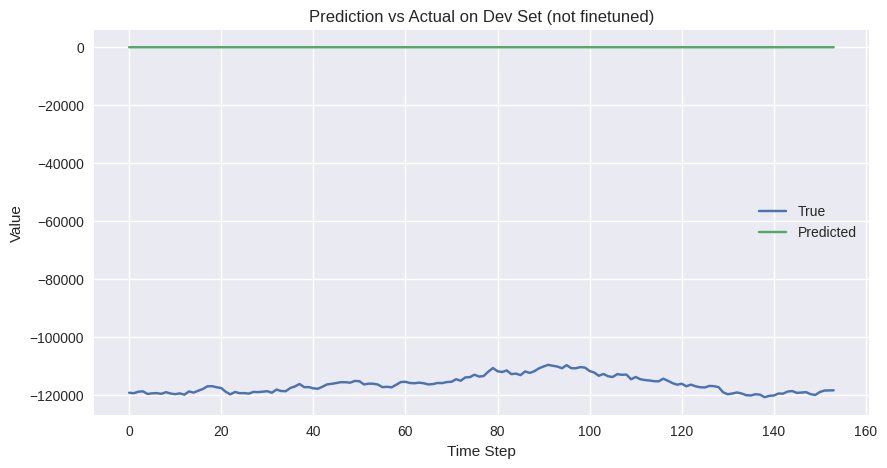

First 10 true values:
[-119369.73  -119531.04  -119014.02  -118886.39  -119798.516 -119563.016
 -119510.67  -119741.79  -119173.836 -119638.266]
First 10 predictions:
[-0.4301312   0.09295426 -0.4013818   0.34674802  0.19603874 -0.7552185
 -0.29569972 -0.4138886  -0.5801339   0.04250915]
First 10 normalized predictions:
tensor([[-0.4301],
        [ 0.0930],
        [-0.4014],
        [ 0.3467],
        [ 0.1960],
        [-0.7552],
        [-0.2957],
        [-0.4139],
        [-0.5801],
        [ 0.0425]])
dev_mean: tensor([[-119395.5000],
        [-119294.4844],
        [-119243.1719],
        [-119178.8750],
        [-119115.9531],
        [-119106.2031],
        [-119115.4609],
        [-119141.6250],
        [-119179.2734],
        [-119186.1875],
        [-119238.5000],
        [-119330.3594],
        [-119409.0625],
        [-119460.4219],
        [-119411.9141],
        [-119388.0625],
        [-119369.3281],
        [-119323.3281],
        [-119207.0781],
        [-119122.2266

In [10]:
# def execute_timemoe_workflow(...):
if not target_col in pairs_timeseries.columns:
  raise KeyError(f"pairs_timeseries must contain {target_col}")

# burn the first 30 elements
pairs_timeseries_burned = pairs_timeseries.iloc[burn_in:].copy()

total_len = len(pairs_timeseries_burned)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)
test_size  = total_len - train_size - dev_size # not used, but for clarity

# Standard version of the Time-MoE model can only take in univariate time series. Therefore, we will train only on the target_col
pairs_timeseries_burned_univariate = pairs_timeseries_burned[target_col]

train = pairs_timeseries_burned_univariate[:train_size]
dev   = pairs_timeseries_burned_univariate[train_size:train_size+dev_size] # aka validation
test  = pairs_timeseries_burned_univariate[train_size+dev_size:]

if verbose:
    print(f"Split sizes — train: {len(train)}, dev: {len(dev)}, test: {len(test)}")

seqs = torch.randn(batch_size, look_back)  # tensor shape is [batch_size, context_length] // [64, 20]

# get same shape as seqs for train, dev test using dataloader objects
def create_sequences(series, look_back):
    X = []
    y = []
    for i in range(len(series) - look_back):
        seq = series.iloc[i:i+look_back].values
        target = series.iloc[i+look_back]
        X.append(seq)
        y.append(target)

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    # Normalize X
    mean, std = X.mean(dim=-1, keepdim=True), X.std(dim=-1, keepdim=True)
    X_scaled = (X - mean) / std

    # Normalize y using the same mean and std as X
    y = y.unsqueeze(-1)  # reshape to [N, 1] for broadcasting
    y_scaled = (y - mean) / std
    y = y.squeeze(-1)     # back to [N]
    y_scaled = y_scaled.squeeze(-1)

    return X, X_scaled, y, y_scaled, mean, std

trainX_raw, trainX_scaled, trainY_raw, trainY_scaled, train_mean, train_std = create_sequences(train, look_back)
devX_raw, devX_scaled, devY_raw, devY_scaled, dev_mean, dev_std = create_sequences(dev, look_back)
testX_raw, testX_scaled, testY_raw, testY_scaled, test_mean, test_std = create_sequences(test, look_back)

dev_loader = DataLoader(TensorDataset(devX_scaled), batch_size=batch_size)

if verbose:
  print(f"Shape: {next(iter(dev_loader))[0].shape}") # a single tensor in dev_loader now has shape [batch_size, look_back] as expected

model = AutoModelForCausalLM.from_pretrained(
    'Maple728/TimeMoE-50M',
    device_map="cpu",  # use "cpu" for CPU inference, and "cuda" for GPU inference.
    trust_remote_code=True,
)

prediction_length = 1
output = model.generate(devX_scaled, max_new_tokens = prediction_length)
normed_predictions = output[:, -prediction_length:]

# inverse normalize
predictions = normed_predictions * dev_std + dev_mean
predictions = normed_predictions.squeeze(-1)
predictions = predictions.detach().numpy()
predictions

# compare against devY_scaled
true_values = devY_raw.numpy()  # if you want to compare in original scale

mse = mean_squared_error(true_values[:len(predictions)], predictions)
print(f"Pre-trained Validation MSE (not finetuned yet): {mse}")

plt.figure(figsize=(10, 5))
plt.plot(true_values[:len(predictions)], label='True')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title("Prediction vs Actual on Dev Set (not finetuned)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.show()

print("First 10 true values:")
print(true_values[:10])
print("First 10 predictions:")
print(predictions[:10])
print("First 10 normalized predictions:")
print(normed_predictions[:10])
print(f"dev_mean: {dev_mean}, dev_std: {dev_std}")

In [96]:
# def execute_timemoe_workflow(...):
if not target_col in pairs_timeseries.columns:
  raise KeyError(f"pairs_timeseries must contain {target_col}")

# burn the first 30 elements
pairs_timeseries_burned = pairs_timeseries.iloc[burn_in:].copy()

total_len = len(pairs_timeseries_burned)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)
test_size  = total_len - train_size - dev_size # not used, but for clarity

# Standard version of the Time-MoE model can only take in univariate time series. Therefore, we will train only on the target_col
# TODO: Convert to using multivariate again, as this IS possible according to the original time-moe paper!
pairs_timeseries_burned_univariate = pairs_timeseries_burned[target_col]

train = pairs_timeseries_burned_univariate[:train_size]
dev   = pairs_timeseries_burned_univariate[train_size:train_size+dev_size] # aka validation
test  = pairs_timeseries_burned_univariate[train_size+dev_size:]

if verbose:
    print(f"Split sizes — train: {len(train)}, dev: {len(dev)}, test: {len(test)}")

def create_sequences(series, look_back):
    X_raw = series[:batch_size * look_back].to_numpy() # .reshape(batch_size, look_back)
    X_raw = torch.tensor(X_raw, dtype=torch.float32)

    # normalize devX_raw
    mean, std = devX_raw.mean(dim=-1, keepdim=True), devX_raw.std(dim=-1, keepdim=True)
    X_scaled = (devX_raw - mean) / std
    return X_raw, X_scaled, None, None, mean, std

devX_raw, devX_scaled, devY_raw, devY_scaled, dev_mean, dev_std = create_sequences(dev, look_back)
if verbose:
  print(f"devX_raw Shape: {devX_raw.shape}") # entire devX_raw has that shape before dataset and dev_loader logic

dev_ds = TensorDataset(devX_raw) # goal of TensorDataset class: loading and processing dataset lazily
dev_loader = DataLoader(dev_ds, batch_size=batch_size, shuffle=False) # DataLoader takes care of shuffling/sampling/weigthed sampling, batching, using multiprocessing to load the data, use pinned memory etc. (source; https://discuss.pytorch.org/t/what-do-tensordataset-and-dataloader-do/107017)

if verbose:
  print(f"dev_loader tensor Shape: {next(iter(dev_loader))[0].shape}") # a single tensor in dev_loader now has shape [batch_size, look_back] as expected


model = AutoModelForCausalLM.from_pretrained(
    'Maple728/TimeMoE-50M',
    device_map="cpu",  # TODO: use DEVICE = ..
    trust_remote_code=True,
)

if FLASH_ATTN: # if FLASH_ATTN, we assume the flash-attention module is installed, and adapt the model to use that
  model = AutoModelForCausalLM.from_pretrained('Maple728/TimeMoE-50M', device_map="auto", attn_implementation='flash_attention_2', trust_remote_code=True)

prediction_length = 1 # TODO: rather than hardcoding prediction length, make a strategy where we can pick and choose different prediction lengths, and see what is affected by this (returns, std dev, ..)

# forecast in batches from dev dataset
all_predictions = []
for batch in dev_loader:
  inputs = batch[0] # is devX_scaled, for now [1] will return error, later [1] will return devY_scaled :D
  # output = model.generate(inputs, max_new_tokens=prediction_length)  # shape is [batch_size, look_back + prediction_length]
  # normed_predictions = output[:, -prediction_length:]  # shape is [batch_size, prediction_length]

  # from returned dev_mean and dev_std, slice the appropriate slices from the series
  input_size_current = inputs.size()
  print(f"input_size_current: {input_size_current} (expected [batch_size, seq_len], which would be [8, 20] in this case)")
  batch_size_current = input_size_current[0]
  print(f"batch_size_current: {batch_size_current} (compared to original batch size as param of {batch_size})") # What makes this 2? 2 what??
  local_means = dev_mean[:batch_size_current]
  local_stds = dev_std[:batch_size_current]

  # preds = normed_predictions * local_stds + local_means
  # all_predictions.append(preds)

# Concatenate all predictions
# predictions = torch.cat(all_predictions, dim=0)
# predictions

Split sizes — train: 3143, dev: 174, test: 176
devX_raw Shape: torch.Size([160])
dev_loader tensor Shape: torch.Size([8])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


input_size_current: torch.Size([8]) (expected [batch_size, seq_len], which would be [8, 20] in this case)
batch_size_current: 8 (compared to original batch size as param of 8)
input_size_current: torch.Size([8]) (expected [batch_size, seq_len], which would be [8, 20] in this case)
batch_size_current: 8 (compared to original batch size as param of 8)
input_size_current: torch.Size([8]) (expected [batch_size, seq_len], which would be [8, 20] in this case)
batch_size_current: 8 (compared to original batch size as param of 8)
input_size_current: torch.Size([8]) (expected [batch_size, seq_len], which would be [8, 20] in this case)
batch_size_current: 8 (compared to original batch size as param of 8)
input_size_current: torch.Size([8]) (expected [batch_size, seq_len], which would be [8, 20] in this case)
batch_size_current: 8 (compared to original batch size as param of 8)
input_size_current: torch.Size([8]) (expected [batch_size, seq_len], which would be [8, 20] in this case)
batch_size_cur